# DNN

## Instalación de librerías

Si es necesario instalar las librerías, ejecuta en tu terminal o en una celda:

```bash
pip install torch torchvision
pip install scikit-learn pandas numpy matplotlib seaborn
```

Para verificar si CUDA (GPU) está disponible en PyTorch:
```python
import torch
print(torch.cuda.is_available())
```

## **Objetivos**
- Aprender a cargar datos de un archivo CSV en un DataFrame de Pandas.
- Comprender la importancia del preprocesamiento de datos en el entrenamiento de redes neuronales.
- Crear nuestro primer modelo de una red neuronal usando **sklearn** (simple) y **PyTorch** (flexible y potente).
- Comparar diferentes enfoques: desde lo más simple (sklearn) hasta lo más flexible (PyTorch).
- Evaluar el modelo y realizar predicciones.

In [1]:
# Librerías principales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Para modelo simple con sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

# Visualización y análisis
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cpu
CUDA available: False


## **Central eléctrica ciclo combinado**

El conjunto de datos contiene 9568 puntos de datos recogidos de una central eléctrica de ciclo combinado a lo largo de 6 años (2006-2011), con el objetivo de construir una red neuronal para redecir la potencia eléctrica generada.

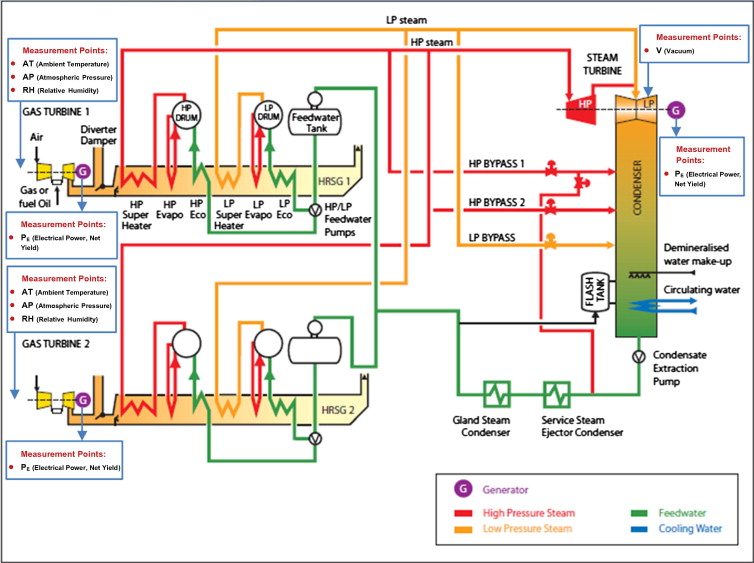

La potencia de las turbinas de gas depende principalmente de los parámetros ambientales (temperatura ambiente, presión atmosférica y humedad relativa), pero también está relacionada con el vacío en el escape de la turbina de vapor. 

Esta base de datos está formada por mediciones horarias de:
- Temperatura (T) en el rango 1,81°C y 37,11°C,
- Presión ambiente (PA) en el rango 992,89-1033,30 milibar,
- Humedad relativa (HR) en el intervalo de 25,56% a 100,16%.
- Vacío de escape (V) en el rango 25,36-81,56 cm Hg
- Producción horaria neta de energía eléctrica (EP) 420,26-495,76 MW

Los datos están disponibles en [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant).

El primer paso es cargar los datos desde el archivo `CCP.csv` a un `DataFrame` utilizndo la librería **pandas**.

In [2]:
if 'google.colab' in str(get_ipython()):
  data_path = 'https://raw.githubusercontent.com/cursos-COnCEPT/curso-tensorflow/refs/heads/main/CCP.csv'
else:
  data_path = os.getcwd() + '\\CCP.csv'

dataset = pd.read_csv(data_path, sep=',')
dataset.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,478.773301
1,23.64,58.49,1011.40,74.20,444.043300
2,29.74,56.90,1007.15,41.91,437.053300
3,19.07,49.69,1007.22,76.79,451.383301
4,11.80,40.66,1017.13,97.20,466.136700


En algunos casos, resulta interesante explorar los datos antendiendo a medidas estadísticas.

In [3]:
dataset.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.400863
std,7.452473,12.707893,5.938784,14.600269,17.127308
min,1.810000,25.360000,992.890000,25.560000,419.863300
25%,13.510000,41.740000,1009.100000,63.327500,439.849975
50%,20.345000,52.080000,1012.940000,74.975000,451.508350
75%,25.720000,66.540000,1017.260000,84.830000,468.556699
max,37.110000,81.560000,1033.300000,100.160000,497.466700


Así como representar los datos de forma gráfica.

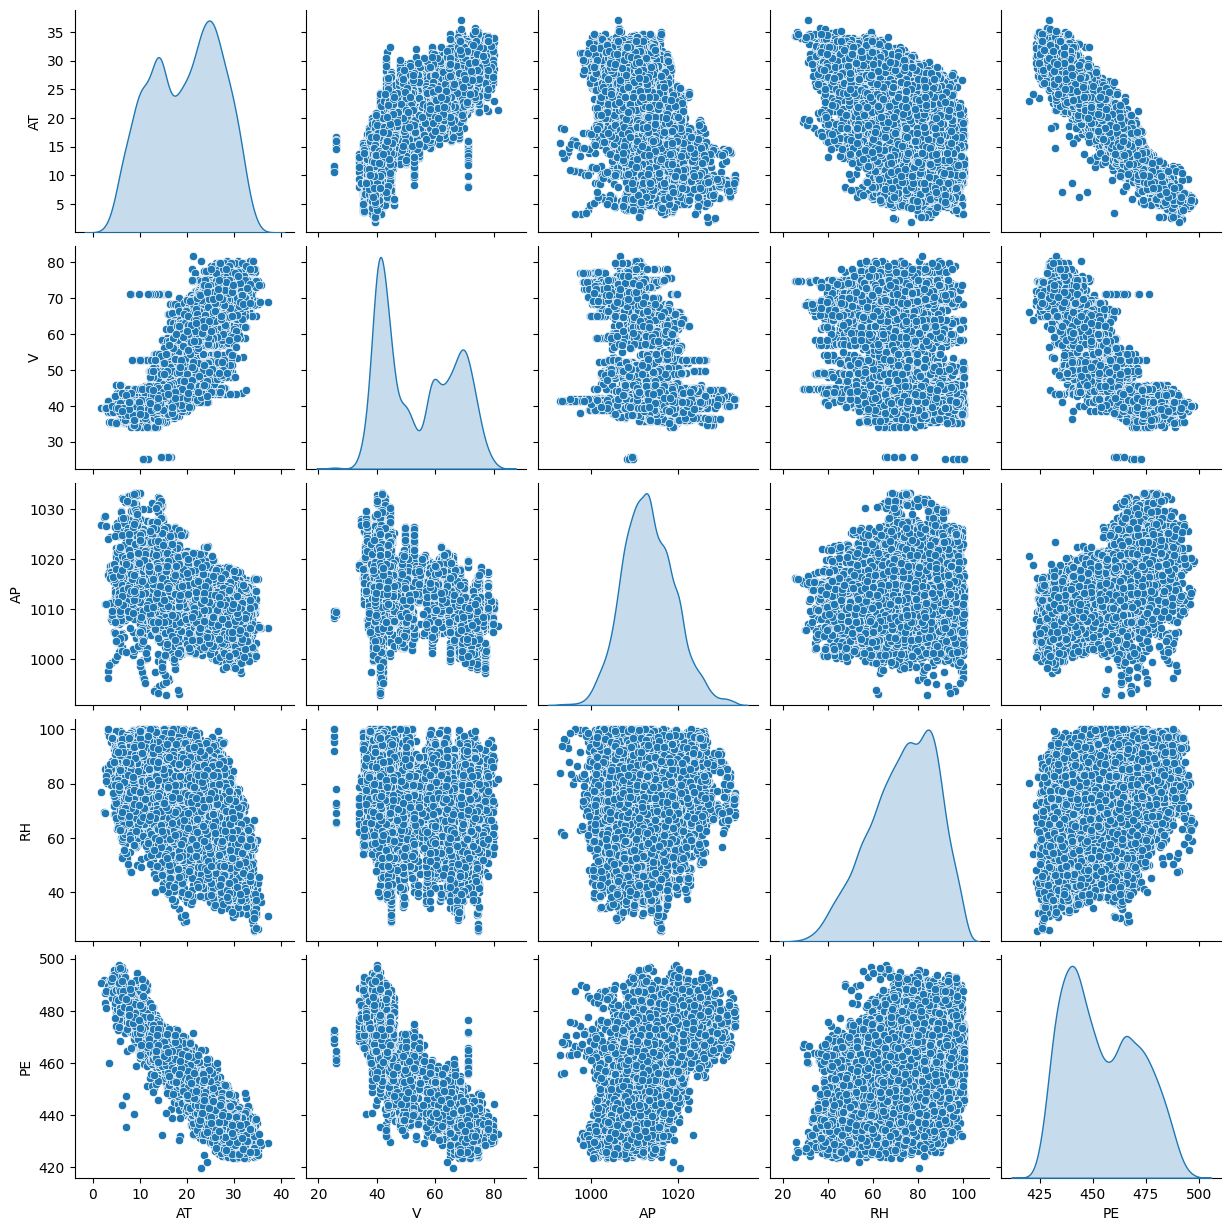

In [4]:
import seaborn as sns

sns.pairplot(dataset, diag_kind='kde')

### **Preprocesamiento de datos**
#### 1 - División o *train-test-validation split*

Nuestro objetivo es crear un modelo que generalice bien a los datos no vistos y no simplemente que se ajuste perfectamente a algunos datos vistos. Por este motivo debemos asegurar que al dividir los datos, el conjunto de `test` sea lo más parecido a los datos "futuros" con los que se empleará la red neuronal una vez entrenada.

En este caso, basta con dividir nuestro *dataset* de forma aleatoria. Sin embargo, hay situaciones más complejas en las que hay que tener cuidado con cómo se hace el reparto. Puedes aprender más sobre el *stratified splitting* [aquí](https://scikit-learn.org/stable/modules/cross_validation.html#stratification).

In [5]:
train_ratio = .7
test_ratio = .15
val_ratio = .15

X = dataset.sample(frac=train_ratio+val_ratio, random_state=0)
X_test = dataset.drop(X.index)
X_train = X.sample(frac=train_ratio/(val_ratio+train_ratio), random_state=0)
X_val = X.drop(X_train.index)

y_train = X_train.pop('PE')
y_test = X_test.pop('PE')
y_val = X_val.pop('PE')

#### 2 - Normalización (Escalado) 
El análisis estadístico ha sido útil para identificar cómo las variables de entrada tienen diferentes escalas, lo cual puede afectar al proceso de entrenamiento, ya que las variables que se mueven en un rango más amplio tienen mayor impacto sobre el modelo.

Para evitar que esto ocurra, es recomendable normalizar los datos. Para redes neuronales, la mejor práctica es utilizar **StandardScaler** (Z-scores) del paquete **sklearn**. Esta función estandariza los datos para tener media 0 y desviación estándar 1:
```python
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
```

**¿Por qué StandardScaler en lugar de MinMaxScaler?**
- ✅ Datos centrados en cero → mejor convergencia del gradiente
- ✅ Más robusto frente a outliers
- ✅ Práctica estándar en deep learning
- ✅ Funciona mejor con funciones de activación como ReLU, tanh

In [6]:
from sklearn.preprocessing import StandardScaler

Primero inicializamos nuestra función de normalización y después llamamos al comando `fit` para obtener los parámetros de la función, esto es, la **media** y **desviación estándar** de cada variable de entrada en el training set.

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)

,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


**Atención:** el escalado no se aplica a los outputs. ([*Should you scale target values in a regression problem?*](https://www.kaggle.com/discussions/questions-and-answers/181908)).

A continuación, escalamos los datos.

In [8]:
X_train_norm = scaler.transform(X_train)
X_test_norm  = scaler.transform(X_test)
X_val_norm   = scaler.transform(X_val)

## **Opción 1:** Modelo con *sklearn* 

Antes de adentrarnos en PyTorch, empecemos con una aproximación más sencilla usando *sklearn*. Esta librería es ideal para:
- Prototipos rápidos
- Problemas estándar de machine learning
- Cuando no necesitas control total sobre la arquitectura

**Ventajas:**
- Código muy simple (pocas líneas)
- API consistente con otros modelos de sklearn
- Perfecto para empezar

**Limitaciones:**
- Menos flexibilidad en arquitectura
- Menos control sobre el proceso de entrenamiento
- No tan eficiente para datasets muy grandes

### Definición y entrenamiento del modelo *sklearn*

Construye una red neuronal feed-forward, también denominada multilayer perceptron (MLP), utilizando la funcion [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html). La arquitectura debe ser la siguiente:
- 2 capas ocultas con 32 y 16 neuronas, respectivamente
- Función de activación ReLU

En cuanto al proceso de entrenamiento, especifica:
- Optimizador Adam
- Learning rate $\alpha = 10^{-2}$
- 100 iteraciones o épocas

Finalmente, basta con invocar a la función [fit](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor.fit) para entrenar el modelo.

In [9]:
# Definir el modelo
mlp_model = MLPRegressor(
    hidden_layer_sizes=(32, 16),  # Arquitectura: 2 capas ocultas
    activation='relu',             # Función de activación
    solver='adam',                 # Optimizador
    max_iter=100,                  # Número máximo de épocas
    learning_rate_init=0.01,       # Learning rate inicial
    random_state=42,
    verbose=True                   # Mostrar progreso
)

# Entrenar el modelo
mlp_model.fit(X_train_norm, y_train)

Iteration 1, loss = 101502.77350420
Iteration 2, loss = 69548.39388086
Iteration 3, loss = 13534.31014821
Iteration 4, loss = 5416.72954893
Iteration 5, loss = 2312.30255084
Iteration 6, loss = 1017.18119502
Iteration 7, loss = 555.82302157
Iteration 8, loss = 348.92918961
Iteration 9, loss = 232.59082103
Iteration 10, loss = 165.76457492
Iteration 11, loss = 123.77175117
Iteration 12, loss = 95.70941151
Iteration 13, loss = 76.10707581
Iteration 14, loss = 62.52920059
Iteration 15, loss = 52.19109238
Iteration 16, loss = 44.64398192
Iteration 17, loss = 38.23482297
Iteration 18, loss = 33.50997874
Iteration 19, loss = 29.64140432
Iteration 20, loss = 26.50164024
Iteration 21, loss = 24.14640842
Iteration 22, loss = 21.99738553
Iteration 23, loss = 20.42648367
Iteration 24, loss = 18.89779162
Iteration 25, loss = 17.62658818
Iteration 26, loss = 16.65883378
Iteration 27, loss = 15.67584223
Iteration 28, loss = 14.99685766
Iteration 29, loss = 14.42639678
Iteration 30, loss = 13.9249617

,"loss loss: {'squared_error', 'poisson'}, default='squared_error'The loss function to use when training the weights. Note that the""squared error"" and ""poisson"" losses actually implement""half squares error"" and ""half poisson deviance"" to simplify thecomputation of the gradient. Furthermore, the ""poisson"" loss internally usesa log-link (exponential as the output activation function) and requires``y >= 0``... versionchanged:: 1.7 Added parameter `loss` and option 'poisson'.",'squared_error'
,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(32, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the regressor will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate ``learning_rate_`` at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when solver='sgd'.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.01
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",100
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True


### Evaluación del modelo *sklearn*

Para comprobar la eficacia y calidad del modelo que acabas de entrenar, es fundamental evaluar su rendimiento mediante:

1. **Métricas cuantitativas:**
    - **MAE (Mean Absolute Error):** Error promedio en MW, fácil de interpretar
    - **MSE (Mean Squared Error):** Penaliza más los errores grandes
    - **R² (Coeficiente de determinación):** Indica qué porcentaje de la variabilidad es explicada por el modelo (1.0 = perfecto)

2. **Visualización gráfica:**
    - **Gráfico "Observed vs Predicted":** Permite identificar visualmente la calidad del ajuste. La diagonal representa la predicción perfecta (donde predicción = valor real).
    - **Gráfico de residuos:** los **residuos** son las diferencias entre los valores reales y las predicciones. Analizar los residuos ayuda a identificar heteroscedasticidad (varianza no constante) o encontrar outliers problemáticos.

**Objetivo**
- MAE bajo → predicciones cercanas a los valores reales
- R² cercano a 1 → el modelo explica bien la variabilidad
- Puntos cerca de la línea diagonal → buena capacidad predictiva
- Rendimiento similar en train y test → el modelo generaliza bien (no hay overfitting)

Ejecuta la siguiente celda para evaluar el modelo:

In [10]:
# Realizar predicciones
y_pred_train_mlp = mlp_model.predict(X_train_norm)
y_pred_test_mlp = mlp_model.predict(X_test_norm)

# Calcular métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae_train = mean_absolute_error(y_train, y_pred_train_mlp)
mae_test = mean_absolute_error(y_test, y_pred_test_mlp)
mse_test = mean_squared_error(y_test, y_pred_test_mlp)
r2_test = r2_score(y_test, y_pred_test_mlp)

print(f"MAE en train: {mae_train:.2f} MW")
print(f"MAE en test: {mae_test:.2f} MW")
print(f"MSE en test: {mse_test:.2f}")
print(f"R² en test: {r2_test:.4f}")

MAE en train: 3.68 MW
MAE en test: 3.78 MW
MSE en test: 22.39
R² en test: 0.9247


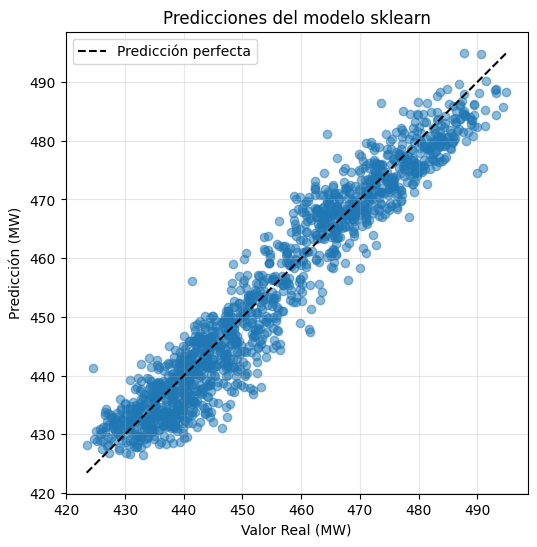

In [11]:
# Gráfico observed vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_mlp, alpha=0.5)
plt.xlabel('Valor Real (MW)')
plt.ylabel('Predicción (MW)')
plt.title('Predicciones del modelo sklearn')
p1 = max(max(y_pred_test_mlp), max(y_test))
p2 = min(min(y_pred_test_mlp), min(y_test))
plt.plot([p2, p1], [p2, p1], '--k', label='Predicción perfecta')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('square')
plt.show()

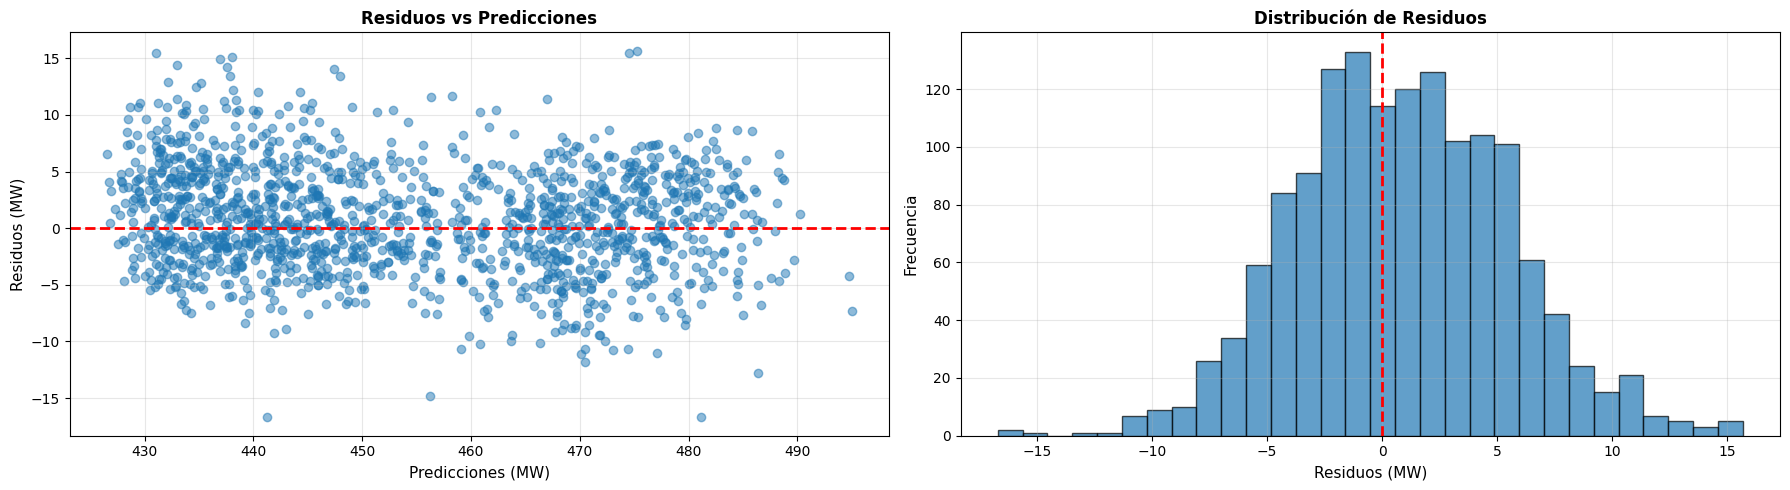

In [12]:
# Calcular residuos
residuals_mlp = y_test - y_pred_test_mlp

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# 1. Residuos vs Predicciones
axes[0].scatter(y_pred_test_mlp, residuals_mlp, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicciones (MW)', fontsize=11)
axes[0].set_ylabel('Residuos (MW)', fontsize=11)
axes[0].set_title('Residuos vs Predicciones', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Distribución de residuos (histograma)
axes[1].hist(residuals_mlp, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos (MW)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title('Distribución de Residuos', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Ejercicio - leer la documentación

Para aprender sobre *machine learning* o programación en general, es fundamental saber manejarse con la documentación de las diferentes herramientas y extraer la información que nos interesa.

Visita la [web de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) y contesta la siguiente pregunta:
- ¿Cuáles son la **media** y **desviación estándar** que se utilizan para normalizar los datos?

In [13]:
# Completa con tu código aquí
mean_values = scaler.mean_
std_values = scaler.scale_  # scale_ contiene la desviación estándar

print('La media y desviación estándar para cada variable son:')
for i, col in enumerate(X_train.columns):
    print(f'{col}: media = {mean_values[i]:.2f}, std = {std_values[i]:.2f}')

La media y desviación estándar para cada variable son:
AT: media = 19.63, std = 7.42
V: media = 54.27, std = 12.73
AP: media = 1013.23, std = 5.94
RH: media = 73.37, std = 14.54


Es importante conocer qué valores (media y desviación estándar) se han utilizado para normalizar los datos de entrenamiento porque luego deberán aplicarse los mismos a cualquier otro punto en el que se quiera aplicar la red neuronal entrenada para hacer una redicción.

## **Opción 2:** Modelo con PyTorch (enfoque flexible y potente)

Ahora vamos a implementar el mismo modelo usando **PyTorch**, que es la librería preferida en investigación y desarrollo de modelos avanzados porque proporciona:
- Automatic differentiation (cálculo automático de gradientes)
- Soporte nativo para GPU/CUDA
- Arquitecturas altamente customizables
- API intuitiva y pythónica

**Ventajas de PyTorch:**
- Control total sobre cada paso del entrenamiento
- Muy flexible para arquitecturas complejas o experimentales
- Soporte para GPUs (entrenamiento mucho más rápido)

**Requiere:**
- Más código
- Entender conceptos como *tensors*, gradientes, y el *training loop*

**Comparación:**
- sklearn: "Dame los datos, aquí está el modelo" (caja negra)
- PyTorch: "Aquí está la estructura, tú defines cada detalle" (control total)

### 1 - Preparar datos para PyTorch

PyTorch trabaja con **tensors** en lugar de arrays de NumPy, por lo que el primer paso es convertir los datos.

**Resumen del flujo completo:**
```
Datos originales (pandas DataFrame)
    ↓ Normalización con StandardScaler
Arrays NumPy normalizados
    ↓ torch.FloatTensor() - conversión a tensors
Tensors de PyTorch
    ↓ TensorDataset() - emparejar X e y
Dataset organizado en pares (X, y)
    ↓ DataLoader() - crear mini-batches, shuffling
Lotes listos para entrenar eficientemente en GPU/CPU
```

#### Paso 1: De NumPy a PyTorch - [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html)

PyTorch trabaja con **tensors** en lugar de arrays de NumPy. Los tensors son similares a los arrays NumPy, pero están especialmente diseñados para el aprendizaje profundo o *deep learning*.

In [14]:
X_train_tensor = torch.FloatTensor(X_train_norm)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)

X_val_tensor = torch.FloatTensor(X_val_norm)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1)

X_test_tensor = torch.FloatTensor(X_test_norm)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

C:\Users\Isabela\AppData\Local\Temp\ipykernel_9548\1704352139.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:219.)
  y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)


#### Paso 2: Organizar datos - [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset)

Una vez tenemos tensors, necesitamos **emparejar** inputs (X) con outputs (y):
- Agrupa tensores en pares indexados: `dataset[i]` devuelve `(X[i], y[i])`
- Fundamental para que DataLoader pueda crear batches correctamente
- Asegura que cada input va siempre con su output correspondiente

#### Paso 3: Entrenar eficientemente - [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

Sin embargo, entrenar con todos los datos a la vez sería ineficiente (consumiría mucha memoria) e inestable (gradientes muy ruidosos o muy suaves). La solución es utilizar **DataLoader**, que envuelve nuestro dataset y nos proporciona automáticamente:

- **Mini-batches:** Divide los datos en lotes pequeños (ej: 256 ejemplos por lote o *batch size*)
   
- **Shuffling:** Mezcla aleatoriamente los datos en cada época
   - Evita que el modelo memorice patrones del orden de los datos
   - Mejora la generalización y convergencia
   
- **Paralelización:** Carga datos en múltiples threads mientras la GPU entrena

In [15]:
BATCH_SIZE = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Número de batches de entrenamiento: {len(train_loader)}")
print(f"Tamaño de cada batch: {BATCH_SIZE}")

Número de batches de entrenamiento: 27
Tamaño de cada batch: 256


### 2 - Definición del modelo en PyTorch

#### Arquitectura con `nn.Module`

En PyTorch, los modelos se definen como **clases que heredan de [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)**, que es la base o patrón para todos los módulos de red neuronal en PyTorch.

**Estructura típica de un modelo PyTorch:**

```python
class MiModelo(nn.Module):
    def __init__(self):
        super().__init__()
        self.capa1 = nn.Linear(...)
        
    def forward(self, x):
        x = self.capa1(x)
        return x
```
**El método `__init__()`**

Define la **arquitectura** (qué capas tenemos). 7

Para poder comparar, emplea la misma estructura que se utilizó para el modelo de *sklearn* (capas totalmente conectadas y activación ReLU).

**[`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)** - Capa completamente conectada:
- Implementa: $y = xW^T + b$ donde $W$ son los pesos y $b$ es el bias
- Automáticamente inicializa los pesos de forma inteligente

**[`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)** - Función de activación ReLU:
- $\text{ReLU}(x) = \max(0, x)$

**El método `forward()`**

Define cómo se transforman los datos a través de la red:
- **Input:** tensor de forma $(batch\_size, num\_features)$
- **Output:** tensor de forma $(batch\_size, output\_size)$
- PyTorch realiza automáticamente el *backpropagation*

In [16]:
class MLPPytorch(nn.Module):
    """
    Red Neuronal Densa (DNN) para regresión
    Arquitectura: Input -> 32 -> 16 -> Output
    """
    def __init__(self, input_size, hidden_sizes=[32, 16], output_size=1):
        super(MLPPytorch, self).__init__()
        
        # Definir las capas
        self.hidden1 = nn.Linear(input_size, hidden_sizes[0])
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output = nn.Linear(hidden_sizes[1], output_size)
        
        # Función de activación
        self.relu = nn.ReLU()
        
    def forward(self, x):
        """
        Forward pass: define cómo fluyen los datos por la red
        """
        x = self.relu(self.hidden1(x))  # Capa oculta 1 + ReLU
        x = self.relu(self.hidden2(x))  # Capa oculta 2 + ReLU
        x = self.output(x)               # Capa de salida (sin activación)
        return x

# Crear el modelo
num_inputs = X_train.shape[1]
model = MLPPytorch(input_size=num_inputs, hidden_sizes=[32, 16], output_size=1)

# Mover a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

print(model)
print(f"\nDispositivo utilizado: {device}")

MLPPytorch(
  (hidden1): Linear(in_features=4, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

Dispositivo utilizado: cpu


#### Contar parámetros del modelo

In [17]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número total de parámetros entrenables: {total_params}")

Número total de parámetros entrenables: 705


### 3 - Configurar optimizador y función de pérdida

Antes de entrenar, debemos especificar:
1. **Función de pérdida (Loss function)** o función objetivo a minimizar
2. **Optimizador:** algoritmo de optimización para ajustar los pesos
3. **Scheduler (opcional):** Cómo adaptar el *learning rate* durante el entrenamiento

Para problemas de regresión, lo más frecuente es utilizar el Error Cuadrático Medio o **MSE** ([`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)).

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

**Adam** ([`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)) es uno de los optimizadores más populares, donde *learning rate* influye significativamente en el desempleño del algoritmo. Típicamente, toma valores entre 0.001 - 0.01 aunque el aprendizaje es más efectivo si:
- **Comenzamos con LR alto** → Explora rápidamente el espacio de soluciones
- **Terminamos con LR bajo** → Convergencia fina hacia el mínimo

**StepLR** ([`torch.optim.lr_scheduler.StepLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)) reduce el learning rate cada $N$ épocas:
$$
\alpha = \alpha_0 × (\gamma ^ \frac{\text{epoch}}{\text{step size}})
$$

Ejemplo: `step_size=20, gamma=0.5`
- Épocas 0-19: LR = 0.01
- Épocas 20-39: LR = 0.005
- Épocas 40-59: LR = 0.0025
- ... (se reduce a la mitad cada 20 épocas)

In [18]:
loss_fcn = nn.MSELoss()

initial_lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

print(f"Función de pérdida: {loss_fcn}")
print(f"Optimizador: {optimizer}")
print(f"Learning rate inicial: {initial_lr}")

Función de pérdida: MSELoss()
Optimizador: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Learning rate inicial: 0.01


### 4 - Visualizar el learning rate schedule

C:\Users\Isabela\AppData\Local\Temp\ipykernel_9548\4080750625.py:12: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  temp_scheduler.step()


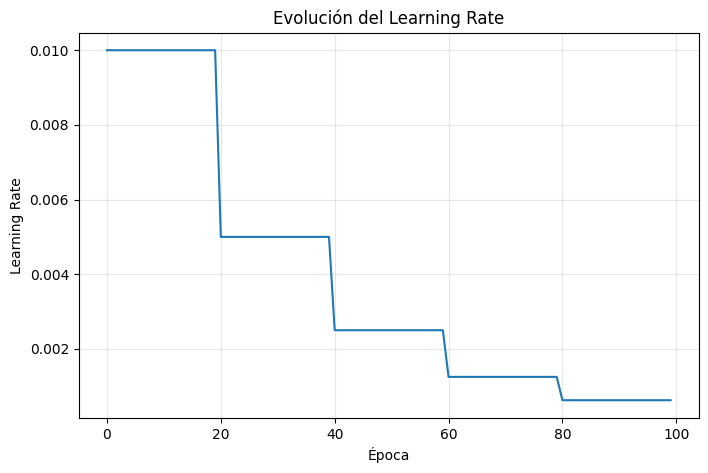

In [19]:
# Simular cómo cambia el learning rate durante el entrenamiento
EPOCHS = 100
lr_history = []
temp_scheduler = optim.lr_scheduler.StepLR(
    optim.Adam(model.parameters(), lr=initial_lr), 
    step_size=20, 
    gamma=0.5
)

for epoch in range(EPOCHS):
    lr_history.append(temp_scheduler.get_last_lr()[0])
    temp_scheduler.step()

plt.figure(figsize=(8, 5))
plt.plot(range(EPOCHS), lr_history)
plt.xlabel('Época')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')
plt.grid(True, alpha=0.3)
plt.show()

### 5 - Entrenamiento (Training Loop)

El **training loop** la función que define el aprendizaje. Generalmente, sigue esta estructura:

```
Para cada época:
    ├─ FASE DE ENTRENAMIENTO (training)
    │  └─ Para cada batch de datos:
    │     ├─ Realizar predicciones (con gradientes)
    │     ├─ Calcular pérdida
    │     ├─ Backward pass: calcular gradientes
    │     └─ Optimización: actualizar pesos
    │
    └─ FASE DE VALIDACIÓN (validation)
       └─ Para cada batch:
          ├─ Realizar predicciones (sin gradientes)
          └─ Calcular métricas de evaluación
```

#### Conceptos clave

**[`model.train()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train) vs [`model.eval()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval):**
- `model.train()`: Activa comportamientos especiales de entrenamiento (dropout, batch norm)
- `model.eval()`: Desactiva estos comportamientos para evaluación

**[`optimizer.zero_grad()`](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step):**
- Pytorch acumula el valor del gradiente, por lo que hay que "resetearlo" en cada iteración antes de cada backward pass

**[`loss.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html):**
- Calcula automáticamente los gradientes usando **Backpropagation**

**[`optimizer.step()`](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step):**
- Actualiza los pesos usando los gradientes calculados
- Para Adam: $\theta := \theta - \text{lr} \times \text{adaptative\_gradient}$

**[`torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html):**
- Desactiva el cálculo automático de gradientes
- Ahorra memoria y cómputo durante validación/evaluación

#### Métricas durante el entrenamiento

Guardamos dos tipos de métricas:
- **Train loss:** En datos que el modelo está viendo durante entrenamiento
- **Validation loss:** En datos que el modelo NO ha visto (detecta overfitting)

**Interpretación:**
- Si train loss ↓ y val loss ↓ → modelo mejorando bien
- Si train loss ↓ y val loss ↑ → **overfitting** (aprende de ruido, no generaliza)
- Si ambos ↑ → **underfitting** (modelo muy simple o lr muy alto)

In [20]:
# Historial de entrenamiento
history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': []
}

# Training loop
for epoch in range(EPOCHS):
    # ==================== ENTRENAMIENTO ====================
    model.train()  # Poner modelo en modo entrenamiento
    train_loss = 0.0
    train_mae = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        predictions = model(X_batch)
        loss = loss_fcn(predictions, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  # Resetear gradientes
        loss.backward()        # Calcular gradientes
        optimizer.step()       # Actualizar pesos
        
        # Acumular métricas
        train_loss += loss.item() 
        train_mae += torch.abs(predictions - y_batch).sum().item()
    
    # Promediar métricas de entrenamiento
    train_loss /= len(train_loader.dataset)
    train_mae /= len(train_loader.dataset)
    
    # ==================== VALIDACIÓN ====================
    model.eval()  # Poner modelo en modo evaluación
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():  # No calcular gradientes en validación
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = loss_fcn(predictions, y_batch)
            
            val_loss += loss.item() 
            val_mae += torch.abs(predictions - y_batch).sum().item() # Calculo error absoluto
    
    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)
    
    # Actualizar learning rate
    scheduler.step()
    
    # Guardar métricas
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    
    # Imprimir progreso cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{EPOCHS}], '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train MAE: {train_mae:.2f}, Val MAE: {val_mae:.2f}, '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')

print("\nEntrenamiento completado.")

Época [10/100], Train Loss: 3.1147, Val Loss: 2.5569, Train MAE: 21.92, Val MAE: 19.63, LR: 0.010000
Época [20/100], Train Loss: 0.4232, Val Loss: 0.3844, Train MAE: 7.97, Val MAE: 7.39, LR: 0.005000
Época [30/100], Train Loss: 0.2222, Val Loss: 0.2228, Train MAE: 5.80, Val MAE: 5.52, LR: 0.005000
Época [40/100], Train Loss: 0.1516, Val Loss: 0.1539, Train MAE: 4.74, Val MAE: 4.53, LR: 0.002500
Época [50/100], Train Loss: 0.1258, Val Loss: 0.1369, Train MAE: 4.40, Val MAE: 4.27, LR: 0.002500
Época [60/100], Train Loss: 0.1140, Val Loss: 0.1257, Train MAE: 4.17, Val MAE: 4.08, LR: 0.001250
Época [70/100], Train Loss: 0.1091, Val Loss: 0.1214, Train MAE: 4.08, Val MAE: 4.00, LR: 0.001250
Época [80/100], Train Loss: 0.1049, Val Loss: 0.1176, Train MAE: 4.00, Val MAE: 3.94, LR: 0.000625
Época [90/100], Train Loss: 0.1014, Val Loss: 0.1160, Train MAE: 3.96, Val MAE: 3.91, LR: 0.000625
Época [100/100], Train Loss: 0.1005, Val Loss: 0.1145, Train MAE: 3.92, Val MAE: 3.88, LR: 0.000313

Entren

In [ ]:
# Visualizar el historial de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida (MSE)
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Época')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Evolución de la Función de Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico de MAE
ax2.plot(history['train_mae'], label='Train MAE')
ax2.plot(history['val_mae'], label='Validation MAE')
ax2.set_xlabel('Época')
ax2.set_ylabel('Mean Absolute Error (MW)')
ax2.set_title('Evolución del Error Absoluto Medio')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6 - Evaluación en el conjunto de test

Después del entrenamiento, evaluamos el modelo en datos nunca vistos (test set).

#### Proceso de evaluación
```python
model.eval()          # Modo evaluación
with torch.no_grad(): # Sin gradientes
    predictions = model(X_test)
    loss = loss_fcn(predictions, y_test)
```

In [ ]:
# Evaluar en el conjunto de test
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_test_device = y_test_tensor.to(device)
    
    test_predictions = model(X_test_device)
    test_loss = loss_fcn(test_predictions, y_test_device).item()
    test_mae = torch.abs(test_predictions - y_test_device).mean().item()

print(f"MSE en test: {test_loss:.4f}")
print(f"MAE en test: {test_mae:.2f} MW")

### 7 - Realizar predicciones y visualización

In [ ]:
# Convertir predicciones a numpy para visualización
test_predictions_np = test_predictions.cpu().numpy().flatten()
y_test_np = y_test.values

# Gráfico observed vs predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test_np, test_predictions_np, alpha=0.5)
plt.xlabel('Valor Real (MW)', fontsize=12)
plt.ylabel('Valor Predicho (MW)', fontsize=12)
plt.title('Predicciones vs Valores Reales (PyTorch)', fontsize=14)

p1 = max(max(test_predictions_np), max(y_test_np))
p2 = min(min(test_predictions_np), min(y_test_np))
plt.plot([p2, p1], [p2, p1], '--k', linewidth=2, label='Predicción perfecta')

plt.xlim([p2, p1])
plt.ylim([p2, p1])
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('square')
plt.show()

#### Gráficos de residuos (PyTorch)

Al igual que con sklearn, analizamos los residuos para evaluar la calidad del modelo.

In [ ]:
# Calcular residuos
residuals_pytorch = y_test_np - test_predictions_np

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# 1. Residuos vs Predicciones
axes[0].scatter(test_predictions_np, residuals_pytorch, alpha=0.5, color='steelblue')
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicciones (MW)', fontsize=11)
axes[0].set_ylabel('Residuos (MW)', fontsize=11)
axes[0].set_title('Residuos vs Predicciones', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Distribución de residuos (histograma)
axes[1].hist(residuals_pytorch, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos (MW)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title('Distribución de Residuos', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparación: sklearn vs PyTorch

### ¿Cuándo usar sklearn?

**Ideal para:**
- Prototipos rápidos y experimentos iniciales
- Problemas estándar de machine learning
- Cuando el tiempo de desarrollo es limitado
- Equipos sin experiencia profunda en deep learning
- Datasets pequeños a medianos

**Código mínimo:**
```python
model = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu')
model.fit(X_train, y_train)
predictions = model.predict(X_test)
```

### ¿Cuándo usar PyTorch?

**Ideal para:**
- Control total sobre arquitectura y entrenamiento
- Modelos personalizados o arquitecturas complejas
- Cuando necesitas GPUs para acelerar el entrenamiento
- Investigación y desarrollo de nuevas técnicas
- Producción a gran escala

**Requiere más código pero más flexible:**
- Definir la arquitectura como clase
- Escribir el training loop completo
- Gestionar dispositivos (CPU/GPU)
- Control granular de cada paso

### Recomendación para este workshop

1. **Empezar con sklearn** para entender conceptos básicos
2. **Avanzar a PyTorch** cuando necesites más control
3. **Comparar resultados** entre ambas aproximaciones

Ambos enfoques son válidos y complementarios. La elección depende del problema y contexto específico.

## Conclusiones

Con este ejemplo hemos aprendido:

* Existen diferentes librerías para implementar redes neuronales, cada una con sus ventajas
* **sklearn** es perfecto para empezar: simple, rápido, efectivo
* **PyTorch** ofrece máximo control y flexibilidad para casos avanzados
* El error cuadrático medio (MSE) es una función de pérdida común para regresión
* El error absoluto medio (MAE) es útil para evaluar el modelo en unidades interpretables
* Cuando las inputs tienen diferentes rangos, debe aplicarse escalado (normalización)
* El learning rate puede ajustarse dinámicamente durante el entrenamiento
* Visualizar el proceso de entrenamiento ayuda a identificar problemas (overfitting, underfitting)

## Próximos pasos

### Para profundizar más:

1. **Overfitting y Early Stopping:** Aprender técnicas de regularización
2. **Hyperparameter Tuning:** Optimizar arquitectura y parámetros de entrenamiento
3. **Batch Normalization:** Técnica para estabilizar y acelerar el entrenamiento
4. **Dropout:** Prevenir overfitting en redes más profundas
5. **Transfer Learning:** Aprovechar modelos pre-entrenados
6. **Guardar y cargar modelos:** Para usar modelos en producción

### Ejercicios propuestos:

1. Modifica la arquitectura (más/menos capas, más/menos neuronas) y compara resultados
2. Prueba diferentes funciones de activación (tanh, sigmoid, LeakyReLU)
3. Experimenta con diferentes optimizadores (SGD, RMSprop, AdamW)
4. Implementa early stopping para detener el entrenamiento cuando el modelo deja de mejorar
5. Añade dropout entre las capas para prevenir overfitting